# Undergraduate Senior Thesis on Course Trading

University of Pennsylvania, Department of Computer and Information Sciences

**Author**: [Charles Cunningham](https://www.linkedin.com/in/charley-cunningham-049a81193/) ([ccunning@seas.upenn.edu](mailto:ccunning@seas.upenn.edu), once graduated: [cunningham3c@gmail.com](mailto:cunningham3c@gmail.com))

**Advisor**: [Aaron Roth](https://www.cis.upenn.edu/~aaroth/) ([aaroth@seas.upenn.edu](mailto:aaroth@seas.upenn.edu))

**Reader**: [Michael Kearns](https://www.cis.upenn.edu/~mkearns/) ([mkearns@seas.upenn.edu](mailto:mkearns@seas.upenn.edu))

## Introduction

> Game theory, the part of economics that studies the "rules of the game," provides a framework with which to address design. But design involves a responsibility for detail; this creates a need to deal with complications. Dealing with complications requires not only careful attention to the institutional details of a particular market, it also requires new tools, to supplement the traditional analytical toolbox of the theorist... [I]n the service of design, experimental and computational economics are natural complements to game theory...
> 
> Another kind of challenge is professional rather than technical, and has to do with whether and how it will become customary to report design efforts in the economics literature. The recent prominence of economists in design arose from several events, external to the profession, that created a need for designs of unusual markets. Not only did this give economists a chance to employ what we know, it gave us a chance to learn practical lessons about design. Whether economists will often be in a position to give highly practical advice on design depends in part on whether we report what we learn, and what we do, in sufficient detail to allow scientific knowledge about design to accumulate... [F]or this purpose, we need to foster a still unfamiliar kind of design literature in economics, whose focus will be different than traditional game theory and theoretical mechanism design.
> 
> [Roth (2002)](https://doi.org/10.1111/1468-0262.00335)

This undergraduate senior thesis delves into the problem of [course allocation](https://en.wikipedia.org/wiki/Course_allocation): allocating seats in classes to students (more generally, allocating heterogeneous indivisible objects without using monetary transfers). With 4 years of experience working on the student developer team behind [Penn Course Plan](https://pennlabs.org/products/penn-course-plan), [Penn Course Alert](https://pennlabs.org/products/penn-course-alert), and [Penn Course Review](https://pennlabs.org/products/penn-course-review) (course planning apps collectively used by 10k+ students), I have learned a lot about course registration at Penn. As a student, I have put much thought and effort into carefully crafting my own 4-year course plan, including fighting the battle of course registration each semester. Since freshman year, I have been keenly aware of the inefficiencies of traditional mechanisms for course allocation, and interested in finding solutions. Besides contributing to course planning software used by over 10k students/faculty each semester, I set up a facebook group for [course trading at Penn](https://www.facebook.com/groups/759880114532358/), which quickly grew to 1.7k members. The interest and success stories from that group, as well as my discussion with other students and my own experiences, indicated to me that many pareto improvements existed in the course allocation at Penn, especially later in the add/drop period. This thesis investigates that hypothesis, and discusses ideas and techniques for enabling course trading at Penn (clearing mutually beneficial trades between people who want each others' sections).

![Penn Course Trading Facebook group](https://i.imgur.com/KCm2Tg9.png)

^ Exerpt from [my group's freshman year PennApps slide deck](https://github.com/mureytasroc/penn-course-alert-plus/blob/master/PennApps_Demo.pptx); September, 2019. Some more recent images, including success stories:

<style>
    .grid-container {
        display: grid;
        grid-template-columns: auto auto; /* Two columns of equal width */
        grid-gap: 10px; /* Space between images */
        padding: 10px;
    }
    .grid-item {
        text-align: center;
    }
    img {
        width: 100%; /* Adjust the width as needed */
        height: auto; /* Maintain aspect ratio */
    }
</style>
<div class="grid-container">
    <div class="grid-item">
        <img src="https://i.imgur.com/5Bn4oIG.png" alt="Image 1">
    </div>
    <div class="grid-item">
        <img src="https://i.imgur.com/H8yae96.png" alt="Image 2">
    </div>
    <div class="grid-item">
        <img src="https://i.imgur.com/8R7jLg9.png" alt="Image 3">
    </div>
    <div class="grid-item">
        <img src="https://i.imgur.com/ZiPQ7MT.png" alt="Image 4">
    </div>
</div>


## Course Allocation

There has been much research on the [course allocation problem](https://en.wikipedia.org/wiki/Course_allocation), primarily focused on the initial allocation of courses to students at the beginning of the course selection period.

A frequent issue with proposed course allocation systems is untruthfulness (or non-[strategyproofness](https://en.wikipedia.org/wiki/Strategyproofness)). Untruthful mechanisms require strategic play from students, which can be costly and risky, as discussed by [Roth (2007)](https://www.nber.org/system/files/working_papers/w13530/w13530.pdf). They may unfairly punish students who are less familiar with techniques or information needed to gain an edge in the course allocation process.

Unfortunately, as proved by [Papai (2001)](https://doi.org/10.1111/1097-3923.00066), any strategyproof and Pareto efficient mechanism for this problem (subject to certain other desirable conditions) must be dictatorial. More specifically: "an allocation rule is strategyproof, nonbossy [an agent's preference change cannot change allocation of other agents without changing her own allocation], and satisfies citizen sovereignty [every feasible allocation should be prescribed at some preference profile] if and only if it is a sequential dictatorship. In a sequential dictatorship, agents are assigned their favorite objects that are still available, according to a sequentially endogenously determined hierarchy of the agents. We also establish that replacing nonbossiness with a stronger criterion [total non-bossiness: an agent's change in preferences should not impact other agents unless such an impact is necessitated by feasibility constraints] restricts the characterized class of allocation rules to serial dictatorships, where the hierarchy of the agents is fixed a priori."

[Kojima (2010)](https://doi.org/10.1016/j.econlet.2009.12.029) explains that nonbossiness is a desirable property because it seems unfair for an agent to be able to affect the allocation of other agents by changing their preferences (this could lead to undesirable out-of-market dealing/negotiation).

In the domain of quota allocation (each student has a quota of courses that must be filled exactly), [Hatfield (2009)](https://link.springer.com/article/10.1007/s00355-009-0376-6) generalizes Papai's result to "the most restrictive set of preferences that can be regarded as realistic" (the change in utility from substituting one item for another depends only on those two items, not the other items the agent obtains). This is a generalization because less restrictive / less structured preferences could only have more opportunities for strategic manipulation. Hatfield also relaxes the citizen sovereignty condition (which is a further generalization).

[Random serial dictatorship](https://en.wikipedia.org/wiki/Random_priority_item_allocation) is a natural implementation of a strategyproof and Pareto efficient mechanism for course allocation, randomizing the heirarchy of students.

However, despite their desirable theoretical properties, serial dictatorships are practically undesirable due to the sensitivity of student welfare to their randomly-chosen a priori spot in the heirarchy. Since each student's spot in the heirarchy is fixed for the entire allocation process, these mechanisms clearly don't fairly share welfare among students (although random heirarchy may at least share some notion of expected welfare, and other desirable social objectives could potentially be incorperated into the heirarchy selection, e.g. number of semesters before graduation or GPA). As found by [Budish and Cantillon (2012)](https://www.jstor.org/stable/41724620), serial dictatorships perform worse than theoretically untruthful draft mechanisms in measures of welfare such as the number of students who get their first choice and the average rank of courses per student. They are Pareto efficient because it is impossible to improve students low in the heirarchy without harming students high in the heirarchy, but the inequality created to attain this Pareto optimality significantly harms reasonable measures of welfare.

Therefore, most practical implementations of course allocation (summarized below) do not cling to these theoretical properties, and rather focus more on fairness than absolute theoretical efficiency.

It's worth noting that an add/drop period after initial course allocation (where students can add or drop courses on a first-come-first-served basis) is somewhat similar to a random sequential dictatorship (where heirarchy is randomized at each round), except there is no limit of one course selection per round of all students in the market for a new course. Assuming students are maximally eager to add courses, the time to add a single course roughly imposes the constraint that every student gets to choose their favorite available course (in some random order), proceeding in rounds (with period equal to the human latency of adding a course). While this is outside the scope of this thesis, it might be worth investigating the practical merits of imposing some rate limit on adding courses (e.g. one per hour) to give all students an opportunity to add before the next "round". At least this might better approximate those theoretical properties guaranteed by sequential dictatorship. However, since add/drop does not construct the initial allocation of courses, we shouldn't expect any such theoretical guarantees in general.

Some common approaches to initial course allocation are:
- **Course bidding** or similar point-budget systems (e.g. [Hylland and Zeckhauser (1979)](https://www.jstor.org/stable/1832088)'s lottery mechanism, or direct bidding systems discussed by [Sönmez and Ünver (2010)](https://www.jstor.org/stable/25621516)). Commonly used at business schools, this approach generally involves allocating to each student a budget of fake course money and letting them bid on courses to express their preferences. However, as pointed out by [Budish (2011)](https://doi.org/10.1086/664613), fake money cannot enable the same kinds of efficient matching mechinisms / equilibria as real money, since agents do not have any value for fake money at the end of the course selection period (so those agents who end up with a lot of money but no courses will have 0 utility). Additionally, these mechanisms are often severely untruthful (as argued by [Sönmez and Ünver (2010)](https://www.jstor.org/stable/25621516)). [Kominers, Ruberry, and Ullman (2010)](https://link.springer.com/chapter/10.1007/978-3-642-17572-5_49) point out that course bidding systems typically require strategic play from students, and offer meager welfare guarantees.
- **Course draft**. In a draft mechanism, students take turns selecting courses, round-by-round. Such a mechanism has been used by Harvard Business School since the mid-1990s. As discussed by [Budish and Cantillon (2012)](https://www.jstor.org/stable/41724620), these mechanisms are manipulable in theory, manipulated in practice, and cause significant welfare loss (many more students are harmed by strategic behavior than benefit). Budish and Cantillon propose a "proxy draft" mechanism which attempts to smooth over the issues created by untruthfulness by automatically executing optimal stragic play on behalf of students. [Kominers, Ruberry, and Ullman (2010)](https://link.springer.com/chapter/10.1007/978-3-642-17572-5_49) claim to improve on Budish and Cantillon's mechanism with an improved proxy draft mechanism (which could also be described as proxy bidding). More recently, [Hoshino and Roble-Clark (2014)](https://dl.acm.org/doi/abs/10.5555/2892753.2892954) propose a "Quest Draft" mechanism with similar proxy draft ideas. [Li (2020)](https://doi.org/10.1016/j.jebo.2020.07.030) considers weak preferences (ties allowed) and applies concepts from the [weak preference Top Trading Cycles](https://en.wikipedia.org/wiki/Top_trading_cycle#Preferences_with_indifferences) approach to a course allocation draft mechanism. A crucial problem with course drafts is that they only consider ordinal preferences, ignoring differences in cardinal utility between allocations (e.g. if a student *strongly* wants a certain course, and their next-best choice is significantly worse).
- **Equilibrium mechanisms**. [Budish (2011)](https://www.jstor.org/stable/10.1086/664613) developed a mechanism for finding an (approximate) [competitive equilibrium](https://en.wikipedia.org/wiki/Competitive_Equilibrium) from equal incomes for course allocation known as [A-CEEI](https://en.wikipedia.org/wiki/Approximate_Competitive_Equilibrium_from_Equal_Incomes). Since a competitive equilibrium from equal incomes (CEEI) does not necessarily exist in the setting of indivisible goods, Budish settles for computing an approximate competitive equilibrium from approximately equal incomes. While computationally intensive, [Othman, Sandholm, and Budish (2010)](https://dl.acm.org/doi/abs/10.5555/1838206.1838323) developed an efficient implementation of the A-CEEI mechanism. [Budish, Cachon, Kessler, and Othman (2016)](https://doi.org/10.1287%2Fopre.2016.1544) developed an improved implementation known as CourseMatch. This mechanism has since been commercially implemented by a company called Cognomos, and adopted by Wharton Business School for MBA course allocation (replacing the previous bidding mechanism). A-CEEI is strategyproof in the large, approximately pareto efficient, and satisfies some desirable fairness properties. The approximation error of A-CEEI grows with the number of distinct courses, but not with the number of students or the number of seats in each course. [Soumalias, Zamanlooy, Weissteiner, and Seuken (2022)](https://doi.org/10.48550/arXiv.2210.00954) develop a machine learning approach to elicit more accurate preferences from students using pairwise comparison queries.

A comparison of different course allocations and their properties, as of 2011 (from [Budish (2011)](https://www.jstor.org/stable/10.1086/664613)):

![Course Allocation Comparison Pg1](https://i.imgur.com/qg823qJ.png)
![Course Allocation Comparison Pg2](https://i.imgur.com/A7FmH9Q.png)

## Course Trading (Introduction)

Once an initial course allocation has been determined, there may still exist many opportunities for mutually beneficial trades among students. While these would not exist if the course allocation mechanism were pareto optimal, as discussed above most course allocation mechanisms used in practice are not pareto optimal. Also, in practice, students' preferences change throughout the add/drop period as they gather more information, discuss with friends (e.g. via our schedule sharing feature on Penn Course Plan), or simply rethink prior choices. A lot can change over the course of a few months.

Rather than joining the crowded body of research discussing course allocation, this thesis instead focuses on the topic of enabling course trading among students. However, it may be worth investigating the effect of automatically applying these course trading techniques to allocations produced by non Pareto optimal mechanisms (in practice, to what extent would this compromise truthfulness? Any reduction in fairness is just from making some people better off, which doesn't seem promblematic - as long as the trades are matched in a maximally fair way).

Most practically, course trading could be enabled by matching pairs of students who want each others' sections. Matched students would be emailed with a trade proposal, along with a request for availability in the next 24-48 hours. If both students accept / provide availability, they are both automatically emailed with each others' contact information, and a randomly chosen 5-minute window that fits both students' availabilities (a reminder email is sent at the start of the window). They should call each other at roughly the agreed time, and then over the phone perform the trade manually:
1. Drop both sections at the same time
2. Add each other's sections as quickly as possible

There is a ~1 minute delay in Path status updates and Penn Course Alert notifications, so it's unlikely a manual trade like this would be intercepted by a third-party student (especially since it is executed at a random time).

Clearly this approach to manual trading is limited, risky, and time-consuming. It would be much better if a trade (accepted by both students) could be automatically executed by Path@Penn. This could also enable trading cycles of size greater than 2 (not just pairs of students), which as we will see below, greatly increases the number of trading opportunities. With a larger manual trading group than 2, the chance that not all participants are free to trade at the same time soon, or that one of the edges fall through (a student gets into their desired section without the trade, or simply change their mind) greatly increases. So realistically, if we are limited to manual trading, we should only match pairs of students for trading.

## Experimental Setup

Before we continue our theoretical discussion of course trading, let's setup some data for analysis and experimentation. We will consider an anonymized snapshot of Penn Course Plan and Penn Course Alert data on the day before the end of the add/drop period each semester since spring 2020.

### Imports

In [1]:
!pip install pandas
!pip install ortools
!pip install networkx
!pip install hypothesis
!pip install matplotlib
!pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from ortools.sat.python import cp_model
from hypothesis import given, assume, note, strategies as st
import networkx as nx
from functools import partial
from collections import Counter, defaultdict
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm

### Data

We import anonymized Penn Course Plan / Penn Course Alert data from the fall 2019 - fall 2023 semesters (**snapshotted on the day before the add deadline**), to analyze the graph of
students watching each others' courses. We exclude crosslistings (sections are referenced by their primary listing `full_code`, e.g. `NETS-4120-001`). We have access to the following data:
- `watching[semester]`: Student -> list of sections (`full_code` e.g. `NETS-4120-001`) watched on PCA (in chronological order of watching initiation)
- `est_registration[semester]`: Student -> set of sections (`full_code`) estimated to be their Path registration for the fall 2023 semester
- `section_info[semester]`: Section `full_code` ->
    ```python
    {
        "activity": (
            "Lecture"|"Recitation"|"Lab"|"Seminar"|"Studio"|"Clinic"|"Senior Thesis"
            |"Independent Study"|"Masters Thesis"|"Dissertation"
        ),
        "enrollment": int,  # only available for sections after 2022B and before 2023C (2023C data coming soon)
        "capacity": int,
        "open": bool,
        "permit_required": bool,
        "meetings": {
            "day": "M"|"T"|"W"|"R"|"F",
            "start": float,  # hh:mm is formatted as hh.mm = hh+mm/100
            "end": float     # hh:mm is formatted as hh.mm = hh+mm/100
        }
    }
    ```

Just to increase our sample size, each of these data structures is parameterized by semester (so `watching[semester]` yields a student -> set of sections map... etc).

In [3]:
# Load data

all_semesters = ["2020A", "2020C", "2021A", "2021C", "2022A", "2022C", "2023A", "2023C"]

with open("data/watching.pkl", "rb") as file:
    watching = pickle.load(file)

with open("data/estimated-registration.pkl", "rb") as file:
    est_registration = pickle.load(file)

with open("data/section_info.pkl", "rb") as section_info_file:
    section_info = pickle.load(section_info_file)

In [4]:
def course_code(full_code):
    return full_code and "-".join(full_code.split("-")[:-1])

In [5]:
def is_tradable(semester, section_code):
    """
    Section is tradable iff closed and permit not required for registration.
    """
    section = section_info[semester][section_code]
    if section["permit_required"]:
        return False
    if section["open"]:
        return False
    return True

In [6]:
def are_alternatives(semester, section1_code, section2_code):
    """
    Two sections are alternatives if it's impossible for a student to register for both at the same time.
    """
    section1 = section_info[semester][section1_code]
    section2 = section_info[semester][section2_code]

    # Either they meet at overlapping times:
    for meeting1 in section1["meetings"]:
        for meeting2 in section2["meetings"]:
            if meeting1["day"] != meeting2["day"]:
                continue
            # WLOG, meeting1 starts before meeting2
            if meeting1["start"] > meeting2["start"]:
                meeting1, meeting2 = meeting2, meeting1
            if meeting1["end"] > meeting2["start"]:
                return True

    # Or they are the same activity for the same course
    if course_code(section1_code) == course_code(section2_code):
        if section1["activity"] == section2["activity"]:
            return True
    
    # Or they are both writing seminars
    if section1_code.startswith("WRIT") and section2_code.startswith("WRIT"):
        return True

    return False

In [7]:
def plot_semesters(title, f):
    """
    Helper to plot data across all semesters
    f: semester -> y value
    """
    data = [f(sem) for sem in all_semesters]

    fig, ax = plt.subplots()
    ax.plot(all_semesters, data, marker="o")

    ax.set_title(title)
    ax.set_xlabel("Semester")
    ax.set_ylabel("Value")

    def custom_formatter(x, pos):
        return f"{x:.0f}"

    ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

    ax.grid(True)
    plt.show()

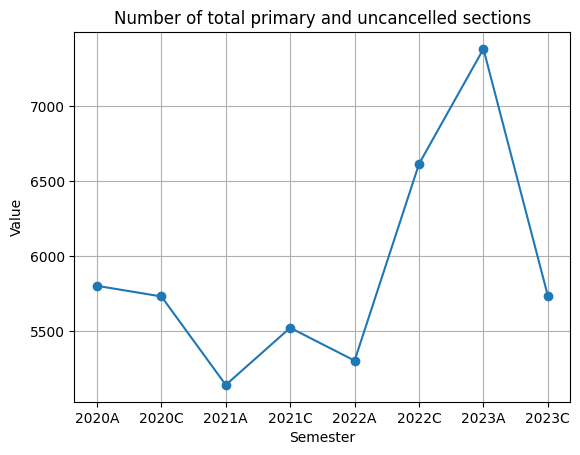

In [8]:
plot_semesters(
    title="Number of total primary and uncancelled sections",
    f=lambda sem: len(section_info[sem]),
)

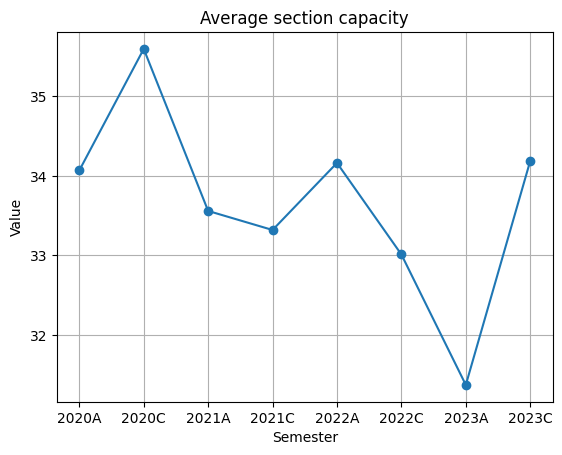

In [9]:
plot_semesters(
    title="Average section capacity",
    f=lambda sem: sum(s["capacity"] for s in section_info[sem].values()) / len(section_info[sem]),
)

NOTE that this data is only available for 2022B <= semester < 2023C


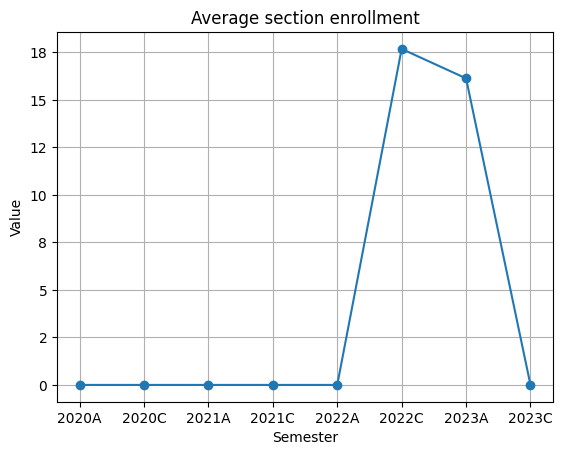

In [10]:
print("NOTE that this data is only available for 2022B <= semester < 2023C")
plot_semesters(
    title="Average section enrollment",
    f=lambda sem: sum(s["enrollment"] for s in section_info[sem].values()) / len(section_info[sem]),
)

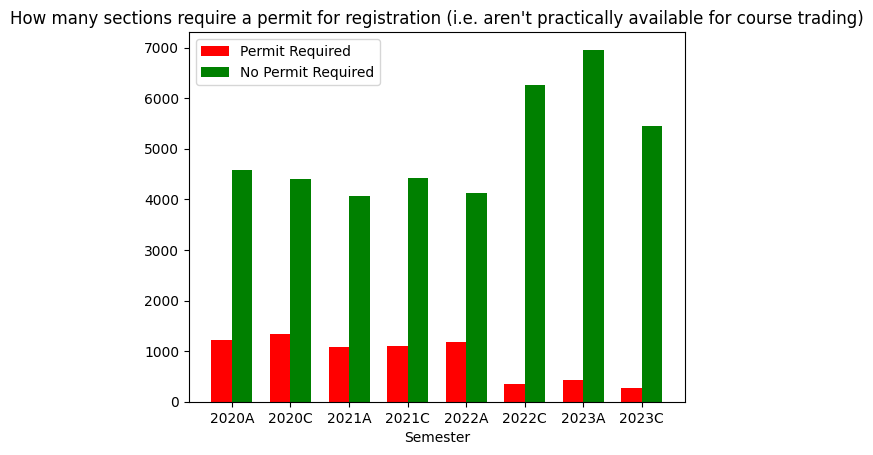

In [11]:
# How many sections require a permit for registration (i.e. aren't practically available for course trading)

counters = {}
for sem in all_semesters:
    counters[sem] = Counter([s["permit_required"] for s in section_info[sem].values()])

true_counts = [counters[sem].get(True, 0) for sem in all_semesters]
false_counts = [counters[sem].get(False, 0) for sem in all_semesters]

fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(all_semesters))

bar1 = ax.bar(index, true_counts, bar_width, color="red", label="Permit Required")
bar2 = ax.bar(
    [i + bar_width for i in index],
    false_counts,
    bar_width,
    color="green",
    label="No Permit Required",
)

ax.set_xlabel("Semester")
ax.set_title(
    "How many sections require a permit for registration (i.e. aren't practically available for course trading)"
)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(all_semesters)
ax.legend()

plt.show()

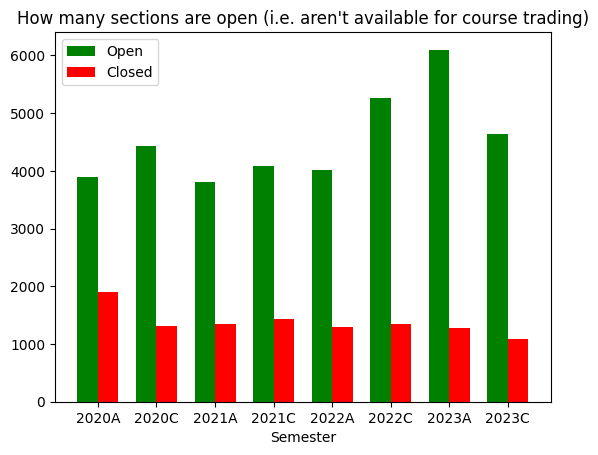

In [12]:
# How many sections are open

counters = {}
for sem in all_semesters:
    counters[sem] = Counter([s["open"] for s in section_info[sem].values()])

true_counts = [counters[sem].get(True, 0) for sem in all_semesters]
false_counts = [counters[sem].get(False, 0) for sem in all_semesters]

fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(all_semesters))

bar1 = ax.bar(index, true_counts, bar_width, color="green", label="Open")
bar2 = ax.bar([i + bar_width for i in index], false_counts, bar_width, color="red", label="Closed")

ax.set_xlabel("Semester")
ax.set_title("How many sections are open (i.e. aren't available for course trading)")
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(all_semesters)
ax.legend()

plt.show()

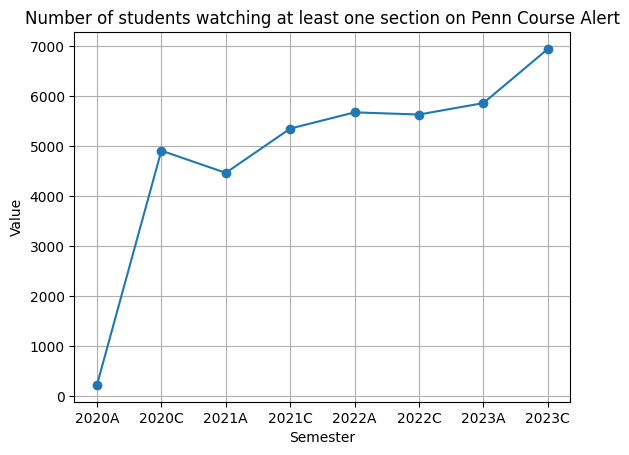

In [13]:
plot_semesters(
    title="Number of students watching at least one section on Penn Course Alert",
    f=lambda sem: len(watching[sem]),
)

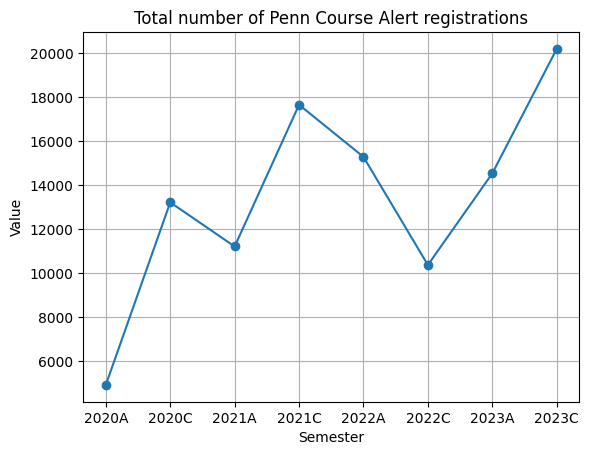

In [14]:
plot_semesters(
    title="Total number of Penn Course Alert registrations",
    f=lambda sem: sum(len(s) for s in watching[sem].values()),
)

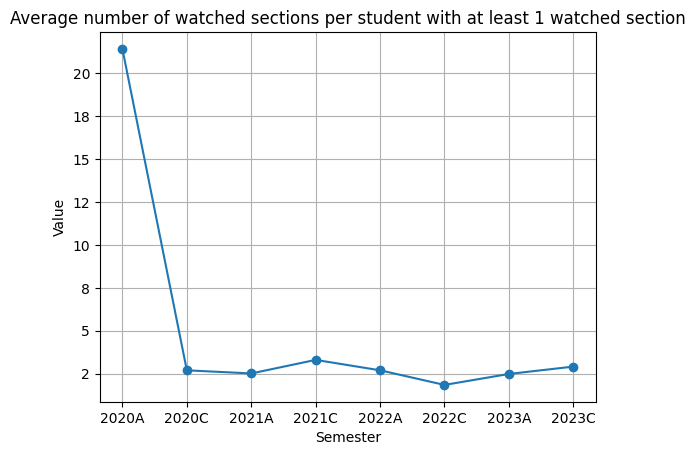

In [15]:
plot_semesters(
    title="Average number of watched sections per student with at least 1 watched section",
    f=lambda sem: sum(len(s) for s in watching[sem].values())  / len(watching[sem]),
)

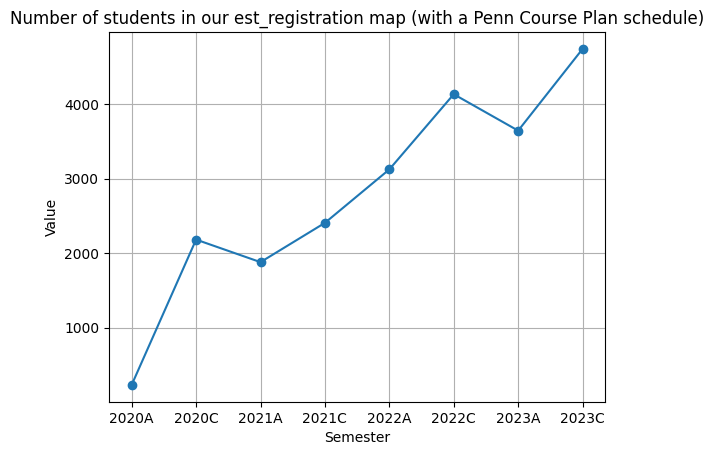

In [16]:
plot_semesters(
    title="Number of students in our est_registration map (with a Penn Course Plan schedule)",
    f=lambda sem: len(est_registration[sem]),
)

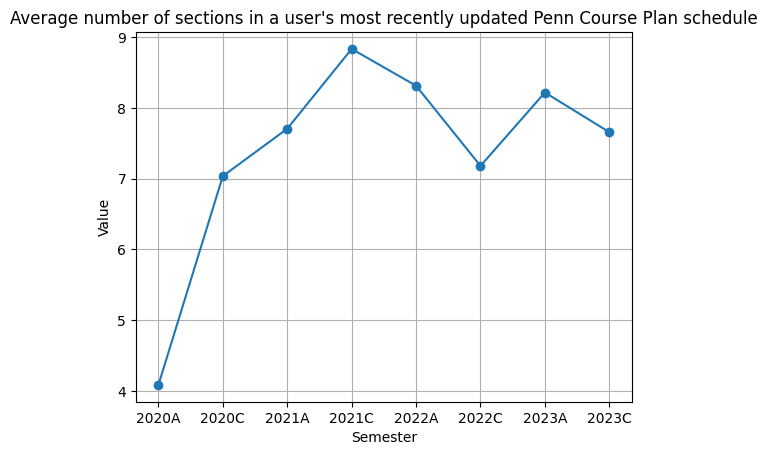

In [17]:
plot_semesters(
    title="Average number of sections in a user's most recently updated Penn Course Plan schedule",
    f=lambda sem: sum(len(s) for s in est_registration[sem].values())  / len(est_registration[sem]),
)

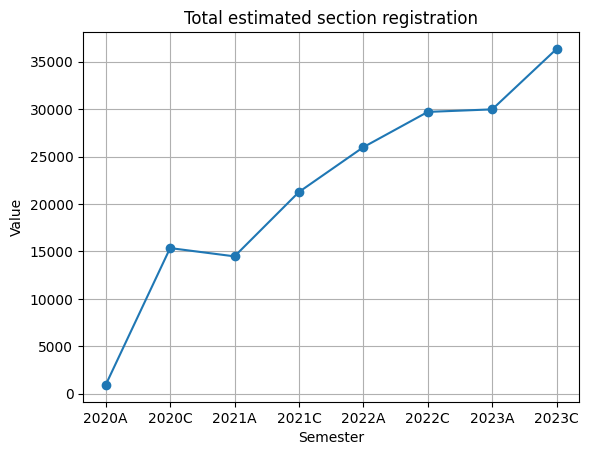

In [18]:
plot_semesters(
    title="Total estimated section registration",
    f=lambda sem: sum(len(s) for s in est_registration[sem].values()),
)

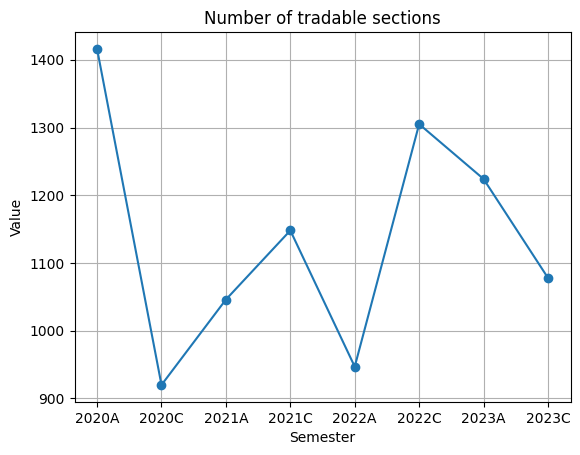

In [19]:
plot_semesters(
    title="Number of tradable sections",
    f=lambda sem: sum(int(is_tradable(sem, sec)) for sec in section_info[sem]),
)

## Preference Languages

Any mechanism for course allocation or course trading needs to collect information about students' preferences over the set of possible schedules. Various mechanisms make different assumptions about the structure of student preferences, as summarized above (in the Course Allocation section).

As mentioned above, with just Penn Course Alert data, we don't have enough information to perfectly match students for generalized course trading.

In fact, to do that perfectly / fully in the worst case, we would need to elicit a truthful preference ordering over all possible course allocations from each student.

Specifying this ordering for even just one student would take exponential size in the number of course sections (in the worst case / ignoring section capacity constraints, $2^{7302} \cdot 5452 \cdot \lg(2^{7302} \cdot 4745) \approx 10^{2205}$ bits, which is about $10^{2123}$ times more than the number of atoms in the universe). Practically, there is a limit to the number of sections any one student can take in one semester. The average is about 7.6 (including recitations/labs/etc), so we would realistically only need about $\binom{7302}{8} \cdot 5452 \cdot \lg(\binom{7302}{8} \cdot 4745)\approx 10^{31}$ bits, or about $10^{18}$ terabytes per student (probably much less in practice, since not all course allocations satisfy section capacity constraints, but still clearly intractable). Not only would this be intractable from a size-of-data standpoint, but also clearly no one has well defined / consistent preferences over *every* allocation of course sections to all students.

One reasonable simplifying assumption might be that each student is *self-interested*, i.e. they only care about the courses allocated to them. While this may not be a perfect assumption (e.g. some students may prefer to take the same class as their friends), it's probably fairly accurate (or at least, the graph of preference dependencies would likely be very sparse). But even assuming self-interested preferences, each student would still have to specify an ordering over all possible schedules we could assign to them, which (even under our size-limited assumption) is $\binom{7302}{8} \cdot \lg(\binom{7302}{8})\approx 10^{28}$ bits, or about 10 billion terabytes. Still obviously intractable.

The only practical solution to this problem is to adopt a "preference language" that allows students to incompletely specify the most important factors determining their preferences between schedules. Some reasonably expressive and concise preference languages have been developed in the course allocation literature. For example, [Othman, Sandholm, and Budish (2010)](https://dl.acm.org/doi/abs/10.5555/1838206.1838323) designed the preference language currently used by Wharton's CourseMatch. They allow each student to report a utility for each section, substitute/compliment adjustments (a positive or negative utility adjustment applied when receiving all sections in a specified set), and a list of constraints of the form "no more than x of the following sections". However, [Budish and Kessler (2014)](https://www.aeaweb.org/conference/2015/retrieve.php?pdfid=2543&tk=BrNDYN8h) found that in practice, students had significant difficulty accureately expressing their preferences in this language:

"We also found evidence, however, that subjects had significant difficulty with preference reporting; in addition, the survey revealed a weakness of CEEI that we had not fully anticipated, which is that subjects found it to be too much of a 'black box.'"

"In the isolated test of preference-reporting accuracy, we find evidence consistent with two sources of preference-reporting mistakes: limitations of the preference-reporting language and difficulty using the preference-reporting language. In the first category, we find evidence that there were certain kinds of non-additive preferences that were important to students but that they were mechanically unable to express using the language provided. This suggests potential scope for enhancing the preference-reporting language. In the second category, we find — consistent with a popular intuition in the matching market design literature — that students more accurately reported ordinal preference information (I like course A better than B) than cardinal preference information (how much I like A better than B)."

To avoid these problems, since we only aim to match students for course trading, we will adopt a different kind of preference language. Rather than attempting to incompletely approximate a preference function over all schedules, we incompletely but precisely characterize the set of trades that a student is willing to make, from their current schedule. This is consistent with the natural language students use to express trade proposals in the Penn Course Trading Facebook group discussed above. The simplest version of our language (presented to the user by default) will allow students to register trade proposals of the form `(incoming_section, outgoing_section)`. While this simple language does not allow a student to completely express their ordinal preferences over the set of possible schedules, it has a few key benefits. It is extremely simple and intuitive for students to understand; compared to CourseMatch's language of assigning numerical values to qualitative preferences between courses (with adjustments for substitutes/compliments and additional constraints), it is absolutely clear what it means to propose a trade of "course A for course B", and easy to accurately decide on. The language exactly maps to the course trading mechanism, improving transparency and mutual understanding among students. Nearly all trade proposals in Penn Course Trading follow this format; it is the natural way for students to express such proposals. This language also benefits from the common intuition in matching market design literature (discussed in [Budish and Kessler (2014)](https://www.aeaweb.org/conference/2015/retrieve.php?pdfid=2543&tk=BrNDYN8h)) - that people typically report ordinal preferences more accurately than cardinal preferences.

Also, over any alternative set (e.g. sections under the same course / same activity), we can allow students to rank (with indifferences) those sections, and apply the [top trading cycles algorithm](https://en.wikipedia.org/wiki/Top_trading_cycle#Preferences_with_indifferences) (with indifferences) to clear trades. The algorithm must tolerate indifferences anyway, since each student is necessarily indifferent between identical copies of the same section owned by other students. (We can also allow students to only partially rank the sections they desire, and assume the student prefers all unspecified sections strictly less than the specified ones and strictly less than their currently-enrolled section, and is otherwise indifferent between the unspecified sections.) The details of how to adapt TTC to course trading are discussed further below.

Expanding our trade proposal language to attain full expressiveness is fairly easy (but leads to many trade clearing difficulties, as discussed below); we can allow students to register trade proposals of the form `(outgoing_sections, incoming_sections)`, where `outgoing_sections` is the set of sections the student will send if the trade proposal is filled, and `incoming_sections` is the set of sections the student requires from the trade. Note that the set of such proposals is an OR, so we can express any possible compound trade proposal (requiring OR of ANDs and offering OR of ANDs) by splitting it up into an OR of proposals in our desired form (the number of simple proposals emitted will equal the product of the number of CNF clauses in the incoming and outgoing specs). We can also allow students to rank their trade proposals by preference (with indifferences). A sufficiently motivated student can completely characterize their ordinal preferences over the set of possible schedules by creating enough trade proposals. However, I claim that the increased expressiveness afforded by this language would not be worth the practical costs; we want students to feel like each trade proposal they make has a reasonable chance of getting filled (otherwise they will not bother registering it). A coincidence of 2 students making exactly opposite trade proposals with compound clauses (e.g. A+B for C // C for A+B) is significantly less likely than exactly opposite simple trade proposals (e.g. A for B // B for A). Anecdotally, most courses at Penn seem to have a single section acting as the "bottleneck" to registration (e.g. either the lecture or the recitation), rather than requiring students to jump through 2 bottlenecks to register (this is likely to avoid catching any students in a situation where they are partially registered for the course). So limiting trade proposals to 1 incoming/outgoing section likely wouldn't significantly reduce the number of trades students are able to make in practice.

One significant downside to this preference language (compared to an approximation of the student's preferences over schedules) is that students may have to update their trade proposals after every change to their schedule, to keep their proposals in line with their preferences. This further supports the hypothesis that students will likely only make a small/manageable number of trade proposals (taking into account the most important changes they wish to make to their schedule), rather than trying to fully characterize their preferences.

## Data Analysis: Trading Opportunities

Now, let's analyze how many pair trading opportunities exist in our data snapshot (ignoring preference rankings over alternatives for now). We construct a graph of student/section pairs, where an edge exists between two nodes if those students want to trade those sections with each other.

In [20]:
pair_trading_graph = dict()
num_alternatives = dict()

for sem in all_semesters:
    G = pair_trading_graph[sem] = nx.Graph()

    # Construct helper dict from tradable section -> set of students who own that section
    tradable_section_owners = {sec: set() for sec in section_info[sem] if is_tradable(sem, sec)}
    for student, owned_sections in est_registration[sem].items():
        for sec in owned_sections:
            if sec not in tradable_section_owners:
                continue
            G.add_node((student, sec))
            tradable_section_owners[sec].add(student)

    # Iterate over all alternative section pairs
    num_alternatives[sem] = 0
    for section1_code, section1_owners in tradable_section_owners.items():
        for section2_code, section2_owners in tradable_section_owners.items():
            if not are_alternatives(sem, section1_code, section2_code):
                continue
            num_alternatives[sem] += 1
            for student1 in section1_owners:
                for student2 in section2_owners:
                    if (
                        section2_code in watching[sem][student1]
                        and section1_code in watching[sem][student2]
                    ):
                        G.add_edge((student1, section1_code), (student2, section2_code))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/mureytasroc/.pyenv/versions/3.11.6/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/jx/dyylvlhn7553c8bl5248z8zw0000gn/T/ipykernel_95125/1133556067.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/mureytasroc/.pyenv/versions/3.11.6/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mureytasroc/.pyenv/versions/3.11.6/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mureytasroc/.pyenv/versions/3.11.6/lib/python3.11/si

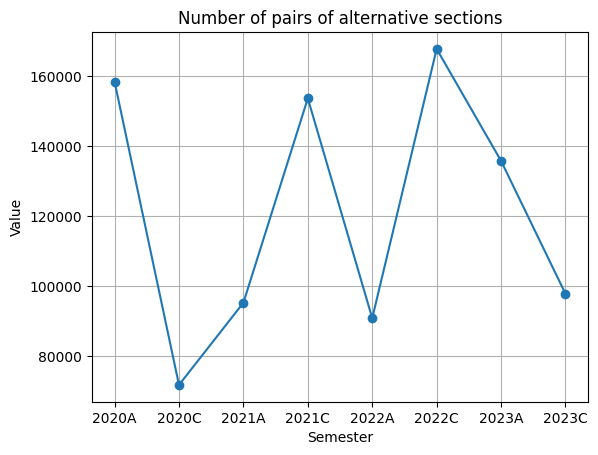

In [ ]:
plot_semesters(
    title="Number of pairs of alternative sections",
    f=lambda sem: num_alternatives[sem],
)

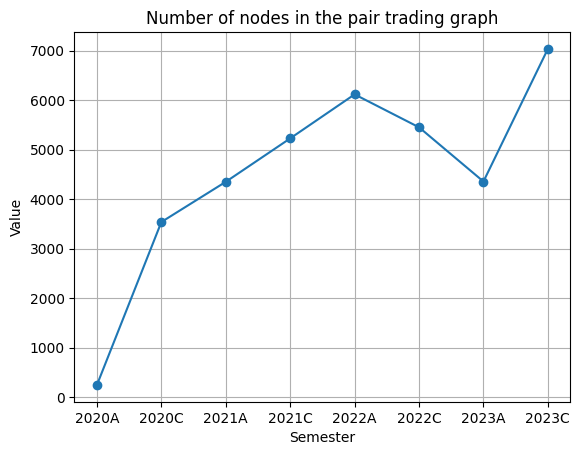

In [ ]:
plot_semesters(
    title="Number of nodes in the pair trading graph",
    f=lambda sem: pair_trading_graph[sem].number_of_nodes(),
)

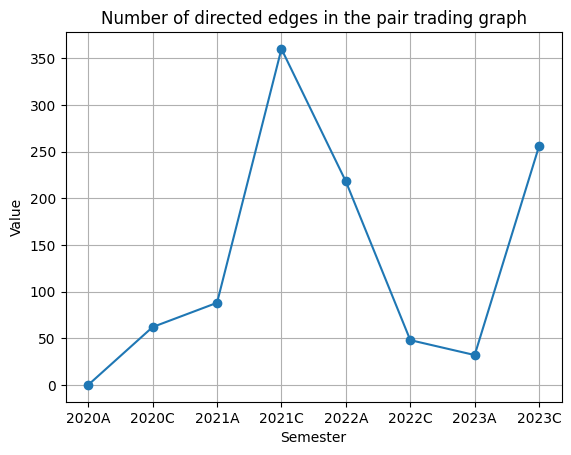

In [ ]:
plot_semesters(
    title="Number of directed edges in the pair trading graph",
    f=lambda sem: 2*pair_trading_graph[sem].number_of_edges(),
)

A "trade segement" is just one of the 2 edges of a trade; we count trade segments so this number is comparable to the general cycle clearing case. To analyze the max number of pair trades in our graph, we simply compute the max cardinality matching.

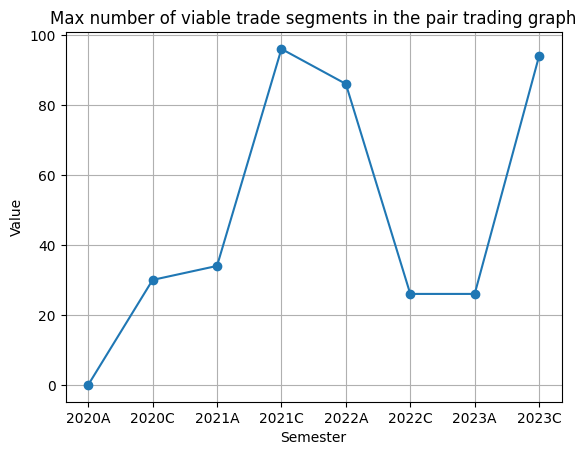

In [ ]:
max_viable_pair_trades = lambda sem: 2*len(nx.max_weight_matching(pair_trading_graph[sem], maxcardinality=True))

plot_semesters(
    title="Max number of viable trade segments in the pair trading graph",
    f=max_viable_pair_trades
)

Let's inspect the sections with pair trading opportunities (from 2023C):

In [ ]:
trades = nx.max_weight_matching(pair_trading_graph["2023C"], maxcardinality=True)
first_participants = [f for (f, _) in trades]
second_participants = [s for (_, s) in trades]

Counter(sec for (_, sec) in first_participants + second_participants)

Counter({'MATH-1410-001': 4,
         'WRIT-0370-301': 3,
         'WRIT-0300-306': 3,
         'WRIT-0110-302': 3,
         'MATH-1070-201': 3,
         'WRIT-0020-314': 3,
         'WRIT-0310-303': 2,
         'MGMT-1010-003': 2,
         'MATH-1070-001': 2,
         'WRIT-0310-304': 2,
         'FNCE-1000-006': 2,
         'WRIT-0830-301': 2,
         'WRIT-0390-303': 2,
         'FNCE-2070-001': 2,
         'MATH-1070-002': 2,
         'MATH-1070-211': 2,
         'WRIT-0300-303': 2,
         'MATH-1070-212': 2,
         'WRIT-0020-303': 2,
         'CIS-1210-213': 2,
         'WRIT-0760-301': 1,
         'CHEM-2410-435': 1,
         'CHEM-2412-151': 1,
         'MATH-1070-202': 1,
         'CIS-1210-215': 1,
         'CHEM-1012-211': 1,
         'MGMT-1010-205': 1,
         'BEPP-2500-001': 1,
         'WRIT-0730-301': 1,
         'MGMT-1010-210': 1,
         'EESC-1000-203': 1,
         'PHYS-0150-121': 1,
         'WRIT-0020-316': 1,
         'CHEM-2410-420': 1,
         'WRIT-0

As expected, lots of writing seminars and courses with many sections.

Now we construct a graph where each node is again a tradable registration (student, tradable section), but now there is a directed edge from A to B if student/section A is willing to trade with/for student/section B (again, ignoring preference rankings for now). This will allow us to get a sense of how many unlimited-length trading opportunities exist (among alternative sections).

In [ ]:
trading_graph = dict()
num_alternatives = dict()

for sem in all_semesters:
    G = trading_graph[sem] = nx.DiGraph()

    # Construct helper dict from tradable section -> set of students who own that section
    tradable_section_owners = {sec: set() for sec in section_info[sem] if is_tradable(sem, sec)}
    for student, owned_sections in est_registration[sem].items():
        for sec in owned_sections:
            if sec not in tradable_section_owners:
                continue
            G.add_node((student, sec))
            tradable_section_owners[sec].add(student)
    
    # Add edges
    for student, owned_sections in est_registration[sem].items():
        for sec in owned_sections:
            if not is_tradable(sem, sec):
                continue
            for watched in watching[sem][student]:
                if not is_tradable(sem, watched):
                    continue
                if not are_alternatives(sem, sec, watched):
                    continue
                for watched_owner in tradable_section_owners[watched]:
                    G.add_edge((student, sec), (watched_owner, watched))

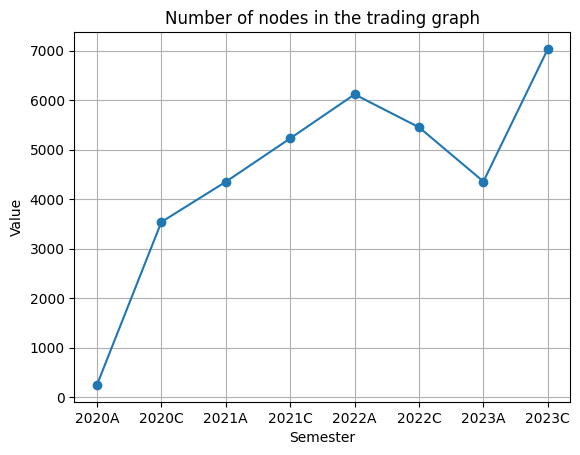

In [ ]:
plot_semesters(
    title="Number of nodes in the trading graph",
    f=lambda sem: trading_graph[sem].number_of_nodes()
)

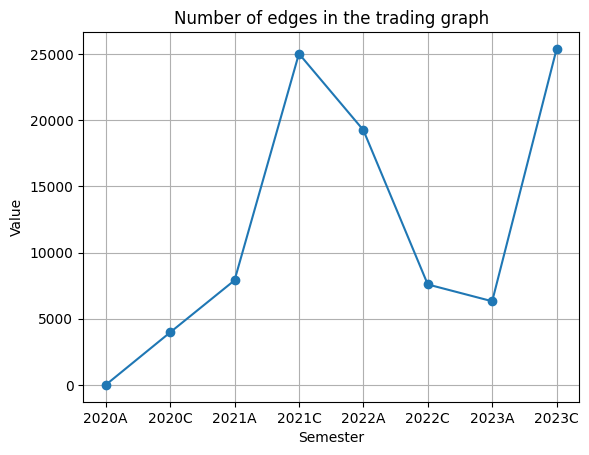

In [ ]:
plot_semesters(
    title="Number of edges in the trading graph",
    f=lambda sem: trading_graph[sem].number_of_edges()
)

[Abraham, Blum and Sandholm (2007)](https://doi.org/10.1145%2F1250910.1250954) showed how to maximally clear trades in a barter economy among alternatives. As we show above, maximally clearing trades under the restriction of length-2 cycles is poly-solvable. And clearing trades generally with no limit on cycle size is poly-solvable. However, adding more restrictive constraints to the cycle size (e.g. length at most $k$ or length at least $k$ for $2<k<|E|$) makes the problem NP complete.

The high level approach is to split each node $u$ in our directed graph $G$ (a (student, section) pair) into two nodes in a new weighted undirected bipartite graph $G'$: $x_u$ and $y_u$. Then we add an edge $(x_u, y_u)$ with weight 1 to $G'$, and for every edge $(u,v)$ in $G$ we add $(x_u, y_v)$ with weight $1+\frac{1}{n}$ to $G'$ (where $n$ is the number of vertices in $G$). Then we find a maximum weight matching in $G'$ using the Blossom algorithm.

For efficiency, we split $G$ into its strongly connected components before matching (since any cycle will be in a single SCC).

In [ ]:
# We compute the max cycle packing (max vertex cover)

num_trading_segments = dict()

for sem in all_semesters:
    num_trading_segments[sem] = 0
    G = trading_graph[sem]
    for scc in nx.strongly_connected_components(G):
        n = len(scc)
        Gp = nx.Graph()
        for u in scc:
            Gp.add_node(("x", u))
            Gp.add_node(("y", u))
            Gp.add_edge(("x", u), ("y", u), weight=1)
        for u in scc:
            for v in G.adj[u]:
                Gp.add_edge(("x", u), ("y", v), weight=1+1/n)
        num_trading_segments[sem] += sum(int(u != v) for ((_, u), (_, v)) in nx.max_weight_matching(Gp))

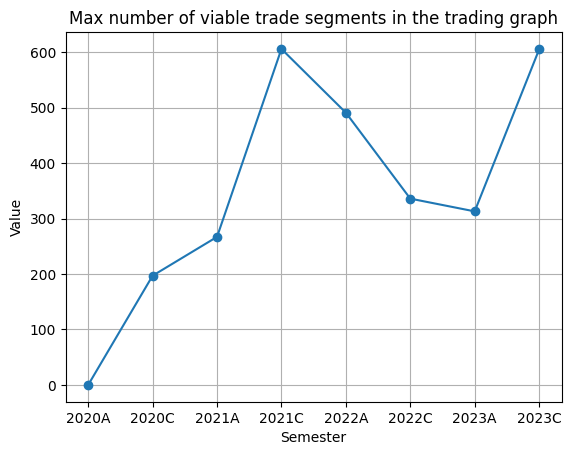

In [ ]:
plot_semesters(
    title="Max number of viable trade segments in the trading graph",
    f=lambda sem: num_trading_segments[sem]
)

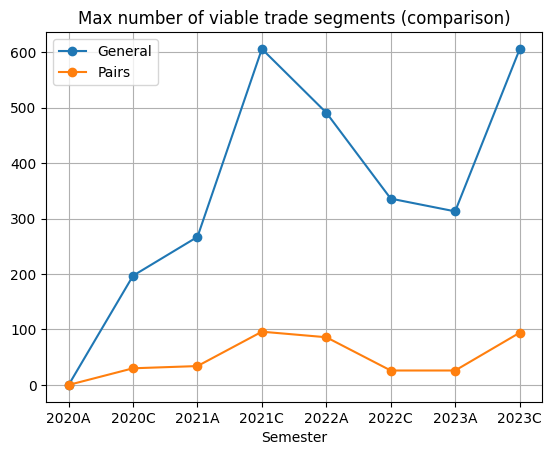

In [ ]:
num_pair_trading_segments = [max_viable_pair_trades(sem) for sem in all_semesters]

fig, ax = plt.subplots()
ax.plot(all_semesters, num_trading_segments.values(), marker="o", label="General")
ax.plot(all_semesters, num_pair_trading_segments, marker="o", label="Pairs")

ax.set_title("Max number of viable trade segments (comparison)")
ax.set_xlabel("Semester")

ax.grid(True)
ax.legend()
plt.show()

This may not seem like a ton of trading opportunities, but a few points are worth noting
- Since we do not currently collect trade proposals from students, we can only assume two students want to trade if they are in alternative sections (as estimated by their most recently updated Penn Course Plan schedule) and are watching each other's sections on Penn Course Alert (or in a cycle of watching, in the general case). However, if we add a feature to Penn Course Alert allowing students to register trade proposals between non-alternative sections, the space of possible trade opportunities greatly increases.
- This is at the very end of the add/drop period, and does not reflect trading opportunities earlier in the add/drop period. People may have had a much harder time getting into sections in the absense of trading, or even been discouraged from watching a section on PCA due to too many unsuccessful notifications. However, all trading opportunities at the end of the add/drop period are guaranteed to have strictly improved those involved students' academic experiences with respect to their preferences, if they were executed.
- We are currently using estimated registration from Penn Course Alert (only used by a subset of the student body), however we are about to merge [a feature](https://github.com/pennlabs/penn-mobile-ios/pull/495) to Penn Mobile to sync Path Registration with Penn Course Plan as a special schedule. This will enable lots of interesting features in Penn Course Plan such as course recommendation and course trading, and it will also integrate nicely with existing features such as course search by schedule fit and optional schedule sharing with friends.

<center>
    <img src="https://i.imgur.com/idEDUFR.png" alt="Penn Mobile Popup">
</center>

Thus, maximally clearing trades if trading cycles are limited to length 2 (or unlimited length) is poly-time solvable. The [Blossom algorithm](https://en.wikipedia.org/wiki/Blossom_algorithm), which can solve [Max Cardinality Matching](https://en.wikipedia.org/wiki/Maximum_cardinality_matching) for the length-2 case and [Max Weight Matching](https://en.wikipedia.org/wiki/Maximum_weight_matching) for the unlimited cycle case, runs in $O(|V|^2\cdot |E|)$ time. [Micali and Vazirani (1980)](https://doi.org/10.1109%2FSFCS.1980.12) developed a more complicated algorithm that could solve max cardinality matching in $O(\sqrt{|V|}\cdot |E|)$. And we can split our graph of trading pairs up into connected components to improve the scalability of the algorithm, or strongly connected components in the unlimited-length case. Also, [Duan and Pettie (2014)](https://web.eecs.umich.edu/~pettie/papers/ApproxMWM-JACM.pdf) developed a $(1-\epsilon)$-approximate maximum weight matching in linear time (if $\epsilon$ is held constant), which could be used to solve the unlimited-length case.

## Course Trading (Continued)

Now that we have some experimental data to color our discussion, let's continue our theoretical exploration of course trading.

Course trading is very similar to a well-studied problem in the Game Theory and market design literature: the [Kidney Exchange Problem](https://en.wikipedia.org/wiki/Optimal_kidney_exchange). This problem was most famously initially discussed by [Roth, Sönmez, and Ünver (2004)](https://doi.org/10.1162/0033553041382157), who extended the Top Trading Cycles mechanism to find exchange cycles (with the possible presense of altruistic donors) in a Pareto-optimal and incentive compatible way.

[Abraham, Blum, and Sandholm (2007)](https://doi.org/10.1145%2F1250910.1250954) show that optimal barter matching with $k$-bounded cycle size maps to the maximum cycle packing problem, which is NP complete for cycle sizes of $3 \leq k < |E|$. However, the problem size can be reduced by considering each SCC independently (we use this trick above, which makes the code finish a LOT faster on our dataset - without the SCC trick I waited a few minutes and didn't see termination). Additionally, this problem can be modeled as a poly-size IP (with a modeling trick developed by [Constantino, Klimentova, Viana, and Rais (2013)](https://doi.org/10.1016%2Fj.ejor.2013.05.025)) and optimized with industrial-strength solvers such as [Gurobi](https://en.wikipedia.org/wiki/Gurobi_Optimizer). A UPenn CIS minicourse I developed with Jediah Katz ([CIS-1890](https://penncoursereview.com/course/CIS-189/2022A): Solving Hard Problems in Practice) guided students through implementing this IP in Python / [Google OR-Tools](https://developers.google.com/optimization/introduction/python) for the length-limited kidney exchange problem. [Here is the solved notebook](https://www.dropbox.com/scl/fo/bfbdhyualiyjpdy1vuugu/h?rlkey=wi6nlgy3ezrabc704323wlea3&dl=0). Slides and course material are still available on the [course website](https://www.cis.upenn.edu/~cis1890/), although this course is no longer being offered now that Jediah and I are graduated.

So far, we have only been considering pair-trading (under manual execution) and unlimited-length trading (under automated execution). However, $k$-limited-length trading may still be appropriate even under automated trade execution, as students still have to be prompted with a trade proposal (asking for time-limited trade approval) before the cycle can be automatically cleared - the expected time for full approval to be granted increases with the cycle size (as does the probability that approval starts expiring at some edges before other edges grant approval). Realistically, coordinating a cycle of 1000 students (as an extreme example) seems unlikely to succeed, even with automated execution.

So how do we truthfully implement $k$-length limited cycle trading among alternatives? Let's first consider how we would do this with strict preferences, and then we will consider indifferences. We can run a mechanism similar to the Top Trading Cycles algorithm, except at each iteration we select a cycle of length at most $k$ (e.g. using $k$-depth-limited DFS). This will still be truthful, as each student's "choice set" (the set of sections they can immediately obtain via a $\leq k$-length cycle by pointing to them) only increases as the algorithm progresses, and each node is only in a single cycle (since students only point to their top choice). However, we are no longer guaranteed that there will be a cycle to clear at each iteration (in unlimited TTC, we argue that since each student has an out-edge, there must be a cycle to avoid an infinite length path - but now there may just be a cycle of length $>k$). So what do we do if we reach an iteration where there are no cycles of length $\leq k$ but there are cycles of length $>k$? We don't want to give up yet, as there still may be mutually beneficial trades to make. But maintaining truthfulness here is tricky. If we (for example) choose a node in a $>k$-length cycle to give up their top preference ("bumping" them, to break the cycle), would a student be afraid to point at their favorite course if it would create a $>k$-length cycle? Well, no; the remainder of the $>k$-length cycle will never change until the student points at their top preference, completing the cycle (remember, the out-degree of each node is exactly 1). Pointing at a less-than-favorite object would be just as bad as the mechanism bumping them due to the $>k$-length cycle. So it is still dominant for the student to point at their true top preference. However, we still have to be careful. How do we decide which node in the cycle to change? If our selection rule depends on the changed node's lower preferences, that agent may be incentivized to lie about their lower preference (e.g. to trick the mechanism into changing a different node, and matching them with a $\leq k$-length cycle for their top preference). So I propose our selection rule should be to bump the node with the most opportunities for $\leq k$-length cycle-creation; in other words, the node with the largest "choice set" (breaking ties randomly). In some sense, bumping this node is our best bet at quickly enabling valid trading cycles with minimal bumping, under the constraint that we can't trust the bumped node's lower preferences for the purposes of bump selection. The bumped node also has the best shot (in some sense) at getting a highly-ranked object (since his choice set is the greatest size), even though he won't be getting his top choice. As we have argued, this mechanism is truthful. However, we can't be sure that it is Pareto optimal. Maybe there was a better choice of node to bump, enabling better trades with fewer bumps (e.g. maybe our choice of node to bump down the line causes someone to be bumped that didn't need to be). Unfortunately, we have no way to perfectly optimize our bump selection based on the resulting graph, without compromising the truthfulness of the mechanism. It might be worth investigating other bump selection strategies and how the effects of compromised truthfulness compare to increased efficiency in practice. A proof that a matching mechanism in this setting cannot be both truthful and Pareto optimal would also be valuable (or alternatively, a mechanism satisfying both properties).

Also, this truthfulness result only really applies in a setting where agents are only matched for trading *once*, and trade cycles of length $>k$ are impossible. If TTC will run multiple times (and agents anticipate this), the mechanism is no longer truthful. To see this, consider an example where $k=2$, but there exists a trading cycle of length 3 (1/A->2/B->3/C->A). Agent 1 wants B, so they are incentivized to lie and say they want $C$ so that the mechanism will match them with agent 3, and then a future run of the mechanism will match them with agent 2 and give them their truly desired section: B. This is an inherent limitation of the length-limited case, although maybe this behavior is not entirely undesirable. This "gaming of the system" just serves to enable a mutually beneficial trade which has been artificially restricted due to our $k=2$ constraint (rather than improving oneself at the expense of others). In some sense, agent 1 is acting as a societally-beneficial "liquidity provider" in the market for sections (circumventing the double-coincidence-of-wants problem and enabling a mutually beneficial length-3 trading cycle). However, just as liquidity providers in financial markets risk losing money if the market moves against them, agent 1 risks not getting matched with 3 by a future run (e.g. due to 3 getting matched with someone else, or section B opening up, or preferences changing, etc). This consideration also reveals that the optimal choice of $k$ (in the automatically-executed trades setting) depends on balancing the friction of waiting for full trade approval with the potential restriction of mutually beneficial trades.

**Note to reader:** ^ this is original work, as I couldn't find any literature discussing length-limited TTC. Further work on this problem could be useful to improve course trading, but also potentially Kidney Exchange (KE)? Although as discussed by [Roth, Sönmez, and Ünver (2005)](https://doi.org/10.1016/j.jet.2005.04.004), patients are roughly indifferent between compatible Kidneys (so a 0-1 preference approximation is reasonable, in which case the problem reduces to max cycle packing).

In the setting with indifferences (which we really need for course trading, as discussed above), can we still maintain truthfulness without compromising too much efficiency? See this [writeup on TTC with indifferences](https://en.wikipedia.org/wiki/Top_trading_cycle#Preferences_with_indifferences) for the high level approach. For course trading, we would not match students for trading if they would not strictly benefit from the trade (especially under manual execution, if an agent has no strict incentive to make the trade, they likely wouldn't expend the effort to do so). Note that this simplifies the algorithm significantly, and the Highest Priority Object rule just reduces to normal TTC, with indifference ties broken arbitrarily via a globally consistent ordering (and once a student points to a student/section node with the same section as his, he is removed from the graph). Unfortunately, this selection rule is somewhat dictatorial (almost reminiscent of the truthful + Pareto optimal sequential dictatorship from the course allocation problem), effectively imposing an a priori ordering over students. Students higher in the ordering will benefit from preferential treatment throughout the course of the algorithm. At least we can randomize the ordering before each run of TTC so as to not permanently bias the mechanism in favor of certain students. Both selection rules discussed by [Saban and Sethuraman (2013)](https://doi.org/10.1145/2492002.2482574) seem to be similarly dicatorial in our setting. It would be interesting to investigate further whether truthfulness in our setting requires dictatorial / preferential treatment like this. Anyway, our approach discussed above for breaking too-long cycles is still reasonable, although now we can improve our bump selection rule slightly: for each node, we can try changing its pointer to another one of its top-preferred nodes. We then do this for a node such that a $\leq k$-length cycle is created (and optimally, we choose the node that will create the most $\leq k$-length trading opportunities). If no such opportunities exist, we can continue with our normal strict-TTC bump rule.

One important note about running TTC on sets of alternative sections, is that these sets must be disjoint. For example, we cannot run TTC on both course/activity alternative sets *and* meeting-time conflict alternative sets (sets of sections with pairwise-conflicting meeting times). This would compromise the truthfulness of the mechanism (relative preferences for the different alternative sets could influence the reported relative rankings within sets). So I claim Penn Course Alert should only allow students to rank sections with the same course/activity, or writing seminars (maybe there are other similar large groups of alternative courses satisfying the same requirement for everyone), and otherwise report generalized trade proposals (discussed below).

Let's implement our proposed TTC mechanism and see how many trade segments we can clear under different choices of $k$ (for the sake of example, as we don't yet have reported preference data from students, we crudely assume students' ordinal preferences over alternative sections are defined by the timestamp at which they registered for alerts for that section - earlier is higher preference).

In [23]:
ttc_trading_segments = dict()  # map from sem to k to number of trading segments cleared
cycle_length_dist = dict()  # map from sem to k to list of cleared cycle lengths

for sem in all_semesters:
    print(f"\nsemester={sem}")
    ttc_trading_segments[sem] = defaultdict(int)
    cycle_length_dist[sem] = defaultdict(list)

    # Add course/activity alternative sets
    course_activity = defaultdict(set)
    for section, info in section_info[sem].items():
        if section.startswith("WRIT"):
            continue
        course_activity[course_code(section), info["activity"]].add(section)
    alternative_sets = list(course_activity.values())

    # Add WRIT alternative set
    alternative_sets.append(set())
    for section in section_info:
        if section.startswith("WRIT"):
            alternative_sets[-1].add(section)

    # Estimate student preferences over each alternative set
    alternative_set_preferences = []
    for alternative_set in alternative_sets:
        preferences = (
            dict()
        )  # map student to (owned, list of highest to lowest preferred alternatives)
        for student, schedule in est_registration[sem].items():
            for owned_sec in schedule:
                if owned_sec in alternative_set:
                    break
            else:  # Student does not own a section in alternative_set
                continue
            prefs = [s for s in watching[sem][student] if s in alternative_set]
            if not prefs:
                # Student already has their top choice
                continue
            preferences[student] = (owned_sec, prefs)
        alternative_set_preferences.append(preferences)

    for k in list(range(2, 7)) + [None]:
        print(f"k={k}")
        for alternative_set_preference in tqdm(alternative_set_preferences):
            # Run k-length limited TTC on this alternative set
            
            owner = defaultdict(list)
            for student, (owned, _) in alternative_set_preference.items():
                owner[owned].append(student)
            
            pointer = dict()
            for student, (owned, prefs) in alternative_set_preference.items():
                for p in range(len(prefs)):
                    pointer[student, owned] = (prefs, p)
                    if owner[prefs[p]]:
                        break
                else:
                    remove_node((student, owned))

            def follow_pointer(u):
                (prefs, p) = pointer[u]
                new_sec = prefs[p]
                return (owner[new_sec][-1], new_sec)

            def bump_pointer(u):
                (prefs, p) = pointer[u]
                while p < len(prefs) - 1:
                    p += 1
                    if owner[prefs[p]]:
                        pointer[u] = (prefs, p)
                        break
                else:
                    remove_node(u)

            def remove_node(v):
                if v not in pointer:
                    return
                student, sec = v
                del pointer[v]
                owner[sec] = [s for s in owner[sec] if s != student]
                if not owner[sec]:
                    # Bump all nodes pointing to v
                    for u in list(pointer.keys()):
                        if u not in pointer:
                            continue
                        (prefs, p) = pointer[u]
                        pointed_sec = prefs[p]
                        if pointed_sec == sec:
                            bump_pointer(u)

            while pointer:
                u = next(iter(pointer))

                # Explore the cycle starting at u
                cycle = []
                while not cycle or u != cycle[0]:
                    cycle.append(u)
                    u = follow_pointer(u)

                if k is None or len(cycle) <= k:
                    # Clear cycle from graph
                    for v in cycle:
                        remove_node(v)
                    cycle_length_dist[sem][k].append(len(cycle))
                    ttc_trading_segments[sem][k] += len(cycle)
                else:
                    # Bump node with largest "choice set"

                    # Compute transpose of pointer graph
                    rev_pointer = defaultdict(list)
                    for u in pointer:
                        rev_pointer[follow_pointer[u]].append(u)

                    num_choices = defaultdict(int)

                    def dfs(u, origin, depth=0):
                        if depth >= k:
                            return
                        if u != origin:
                            num_choices[origin] += 1
                        for v in rev_pointer[u]:
                            dfs(v, origin, depth + 1)

                    for u in pointer:
                        dfs(u, u)
                    to_bump = max(pointer.keys(), key=lambda u: num_choices[u])
                    bump_pointer(to_bump)


semester=2020A
k=2


100%|██████████| 2946/2946 [00:00<00:00, 1541854.20it/s]


k=3


100%|██████████| 2946/2946 [00:00<00:00, 1659916.66it/s]


k=4


100%|██████████| 2946/2946 [00:00<00:00, 1627772.31it/s]


k=5


100%|██████████| 2946/2946 [00:00<00:00, 1596642.92it/s]


k=6


100%|██████████| 2946/2946 [00:00<00:00, 1474337.14it/s]


k=None


100%|██████████| 2946/2946 [00:00<00:00, 963914.47it/s]


semester=2020C


k=2


 40%|████      | 1157/2873 [01:23<02:03, 13.88it/s]


KeyboardInterrupt: 

In [ ]:
num_pair_trading_segments = [max_viable_pair_trades(sem) for sem in all_semesters]

ttc = lambda k: [ttc_trading_segments[sem][k] for sem in all_semesters]

fig, ax = plt.subplots()
ax.plot(all_semesters, num_trading_segments.values(), marker="o", label="Max (unlimited length)")
ax.plot(all_semesters, ttc(None), marker="o", label="TTC (unlimited length)")
ax.plot(all_semesters, ttc(6), marker="o", label="TTC ($\leq 6$-length)")
ax.plot(all_semesters, ttc(5), marker="o", label="TTC ($\leq 5$-length)")
ax.plot(all_semesters, ttc(4), marker="o", label="TTC ($\leq 4$-length)")
ax.plot(all_semesters, ttc(3), marker="o", label="TTC ($\leq 3$-length)")
ax.plot(all_semesters, num_pair_trading_segments, marker="o", label="Max (pairs)")
ax.plot(all_semesters, ttc(2), marker="o", label="TTC (pairs)")

ax.set_title("Number of trade segments (comparison)")
ax.set_xlabel("Semester")

ax.grid(True)
ax.legend()
plt.show()

### Truthfulness and Spot Preferences

Despite all our effort spent on maintaining truthfulness of our course trading mechanisms relative to "spot" preferences (current preferences at some spot during the add/drop period), it is worth considering that students' spot preferences may predictably change throughout the course of the add/drop period, and differ from their "true" preferences for their final schedule at the end of add/drop.

Students know it will be harder to add highly demanded courses later during add/drop, so under uncertainty about how their preferences will evolve over the next few months + how other students' preferences may change (potentially leading to better trading opportunities), they may upweight their spot preference for more highly demanded courses. Even if a student's "true" (end-of-add/drop) preference may be for section B (which is usually open) rather than section A (which is nearly always full), a student would likely report a higher preference for A than B, until very near the end of add/drop. However, this isn't really "untruthfulness", as it is an accurate reporting of their spot preference at the time. Spot preference can be thought of as some rough measure of how eager the student would be to pick up a given course if it were to open up (e.g. the student received a Penn Course Alert notification).

While course trading mechanisms may influence spot preferences somewhat (by increasing the potential value of holding a more highly-demanded section), I claim that bias already exists (due to uncertainty + FOMO), and the benefits of enabling course trading would outweigh this slight manipulation of spot preferences. Plus, spot preferences would converge to true preferences towards the end of the add/drop period anyway (as the window for trading and possible future changes in preferences runs out).

FOMO will always be a manipulating factor in course preferences - even in "true" preferences at the end of add/drop. The reality is that humans are social creatures, and people often (reasonably) see high demand for something as a social signal for quality or desirability. Under incomplete information, humans naturally prefer to move with consensus rather than against it. And picking a bunch of courses with low demand may suffer from adverse selection (have you ever gotten a haircut from the single barber available on short notice? Or chosen the single empty subway car during rush hour??)

### Handling Non-Alternative Trade Proposals

We have extensively covered the problem of enabling course trading within sets of alternative sections. Now, how do we handle trade proposals across non-alternative sections?

The simplest (and maybe best) approach is to not accept preference rankings over trade proposals, and simply compute a max cycle packing (potentially under a length constraint, as we discuss above). As demonstrated/implemented above, this is poly-time solvable for $k=2$ or unlimited length, and can be modeled as an IP with various practical techniques for other values of $k$.

This may cause students to withold reporting lower-preferred trade proposals, to avoid interfering with their more highly-preferred proposals. But students would likely only report higher-preferred proposals anyway, because they are lazy and don't want to have to manage a huge set of trade proposals they don't care about, especially under changing preferences and schedule (requiring updating of proposals in some cases).

Is there any better way to take into account preferences over trade proposals?

## Closing Thoughts

With all the work we have put into exploring / enabling course trading, we are very close to being able to deploy a course trading feature to production in Penn Course Alert. A HUGE amount of work went into this, most of which does not show up in this notebook. Last year the university completely overhauled their course data system (and re-coded all courses), which caused a huge amount of work behind the scenes at Penn Labs to keep our websites and apps running smoothly (especially Penn Course Review) - and also impeded my efforts to prepare our codebase and database for course trading. However we are now well positioned to roll out course trading on Penn Course Alert (with some simple UI changes and a trade matching cron job). Here is [a list of my PRs](https://github.com/pennlabs/penn-courses/pulls?q=is%3Apr+is%3Aclosed+author%3Amureytasroc) that went to this, not including commits directly to master (my GitHub username is [mureytasroc](https://github.com/mureytasroc)).

## Automated Hypothesis Testing

I didn't end up using this code, but I thought I'd leave it here in case it is useful for further work/exploration. This function uses a Python library called [hypothesis](https://hypothesis.readthedocs.io/) to randomly check an arbitrary "hypothesis" about course allocation: either supporting its validity, or alternatively producing a concise counterexample (by "shrinking" failing examples). I didn't end up needing this code, but thought I'd leave it here for future exploration.

In [ ]:
@given(st.data())
def course_allocation_hypothesis_example(data):
    """
    This function uses the Hypothesis library to test a specified property about course allocation.
    Hypothesis uses a combination of random sampling and (if a counterexample is found)
    shrinking of inputs, to either support the proposed hypothesis with testing
    or find a concise counterexample.
    """

    # ============= Setting up Hypothesis strategies and configuration =============

    num_courses = data.draw(st.integers(1, 1000), label="Number of courses")
    num_students = data.draw(st.integers(1, 500), label="Number of students")

    # Draws a list mapping [0..size-1] to elements drawn from `strat`
    draw_list = lambda size, strat, label: data.draw(
        st.lists(strat, min_size=size, max_size=size), label
    )
    # Draws a list mapping course [0..num_courses-1] to elements drawn from `strat`
    draw_courses_map = partial(draw_list, size=num_courses)
    # Draws a list mapping student [0..num_students-1] to elements drawn from `strat`
    draw_student_map = partial(draw_list, size=num_students)

    # List mapping course to max enrollment
    max_enrollment = draw_courses_map(st.integer(10, 240), label="Course -> max enrollment")

    # List mapping student to desired number of courses
    desired_num_courses = draw_student_map(st.integer(3, 7), label="Student -> desired num courses")

    # Hypothesis strategy for drawing a course
    course_strat = st.integers(min_value=0, max_value=num_courses - 1)

    # List mapping student to (potentially incomplete) list of course preferences
    course_preferences = draw_student_map(
        st.lists(course_strat, max_size=40, unique=True),
        label="Student -> partial course preferences",
    )
    # List mapping student to initially allocated courses
    allocated_courses = draw_student_map(
        st.sets(course_strat, max_size=6), label="Student -> initially allocated courses"
    )

    # Assume we haven't violated the max enrollment constraint already
    assume(
        all(
            enrollment <= max_enrollment[course]
            for course, enrollment in Counter(allocated_courses).items()
        )
    )

    return (
        True  # Replace with True/False evaluation of your property on the given course allocation
    )